# 第4章: 形態素解析
夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt)）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39はmatplotlibもしくはGnuplotを用いるとよい．

In [1]:
!apt-get update -qq
!apt-get install -qq mecab libmecab-dev mecab-ipadic-utf8 gcc build-essential
!mecab -v

mecab of 0.996



In [2]:
!pip install -qq mecab-python3

In [3]:
!wget -q -nc http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt

In [4]:
!cat neko.txt | mecab > neko.txt.mecab

## 30. 形態素解析結果の読み込み
形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [5]:
def solve30(filename):
    sentences = []
    sentence = []
    import re
    rgx = re.compile(r'^(.*?)\t(.*?),(.*?),.*?,.*?,.*?,.*?,(.*?),.*?,.*?$')
    with open(filename, 'r') as f:
        for line in f:
            if 'EOS' in line:
                if sentence:
                    sentences.append(sentence)
                sentence = []
                continue
            m = rgx.match(line)
            if m is not None:
                sentence.append({'surface': m.group(1), 'base': m.group(4), 'pos': m.group(2), 'pos1': m.group(3)})
    return sentences

In [6]:
solve30('neko.txt.mecab')[5]

[{'base': '吾輩', 'pos': '名詞', 'pos1': '代名詞', 'surface': '吾輩'},
 {'base': 'は', 'pos': '助詞', 'pos1': '係助詞', 'surface': 'は'},
 {'base': 'ここ', 'pos': '名詞', 'pos1': '代名詞', 'surface': 'ここ'},
 {'base': 'で', 'pos': '助詞', 'pos1': '格助詞', 'surface': 'で'},
 {'base': '始める', 'pos': '動詞', 'pos1': '自立', 'surface': '始め'},
 {'base': 'て', 'pos': '助詞', 'pos1': '接続助詞', 'surface': 'て'},
 {'base': '人間', 'pos': '名詞', 'pos1': '一般', 'surface': '人間'},
 {'base': 'という', 'pos': '助詞', 'pos1': '格助詞', 'surface': 'という'},
 {'base': 'もの', 'pos': '名詞', 'pos1': '非自立', 'surface': 'もの'},
 {'base': 'を', 'pos': '助詞', 'pos1': '格助詞', 'surface': 'を'},
 {'base': '見る', 'pos': '動詞', 'pos1': '自立', 'surface': '見'},
 {'base': 'た', 'pos': '助動詞', 'pos1': '*', 'surface': 'た'},
 {'base': '。', 'pos': '記号', 'pos1': '句点', 'surface': '。'}]

## 31. 動詞
動詞の表層形をすべて抽出せよ．

In [7]:
def solve31(filename):
    return [d['surface'] for sentence in solve30(filename) for d in sentence if d['pos'] == "動詞"]

In [8]:
solve31('neko.txt.mecab')[:10]

['生れ', 'つか', 'し', '泣い', 'し', 'いる', '始め', '見', '聞く', '捕え']

## 32. 動詞の原形
動詞の原形をすべて抽出せよ．

In [9]:
def solve32(filename):
    return [d['base'] for sentence in solve30(filename) for d in sentence if d['pos'] == "動詞"]

In [10]:
solve32('neko.txt.mecab')[:10]

['生れる', 'つく', 'する', '泣く', 'する', 'いる', '始める', '見る', '聞く', '捕える']

## 33. サ変名詞
サ変接続の名詞をすべて抽出せよ．

In [11]:
def solve33(filename):
    return [d['base'] for sentence in solve30(filename) for d in sentence if d['pos1'] == "サ変接続"]

In [12]:
solve33('neko.txt.mecab')[:10]

['見当', '記憶', '話', '装飾', '突起', '運転', '記憶', '分別', '決心', '我慢']

## 34. 「AのB」
2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [13]:
def solve34(filename):
    noun_phrases = []
    
    is_noun = lambda d: d['pos'] == "名詞"
    is_no = lambda d: d['surface'] == "の" and d['pos'] == "助詞" and d['pos1'] == "連体化"
    for sentence in solve30(filename):
        tmp = ''
        step = 0
        for d in sentence:
            if step == 2:
                if is_noun(d):
                    noun_phrases.append(tmp + d['surface'])
                step = 0
                tmp = ''
            elif step == 1:
                if is_no(d):
                    tmp += d['surface']
                    step = 2
                elif is_noun(d):
                    tmp = d['surface']
                else:
                    step = 0
                    tmp = ''
            elif is_noun(d):
                tmp = d['surface']
                step = 1
    return noun_phrases

In [14]:
solve34('neko.txt.mecab')[:10]

['彼の掌', '掌の上', '書生の顔', 'はずの顔', '顔の真中', '穴の中', '書生の掌', '何の事', '肝心の母親', '藁の上']

## 35. 名詞の連接
名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [15]:
def solve35(filename):
    noun_phrases = []
    is_noun = lambda d: d['pos'] == "名詞"
    for sentence in solve30(filename):
        tmp = ''
        length = 0
        for d in sentence:
            if is_noun(d):
                tmp += d['surface']
                length += 1
            else:
                if length > 1:
                    noun_phrases.append(tmp)
                tmp = ''
                length = 0
    return noun_phrases

In [16]:
solve35('neko.txt.mecab')[:10]

['人間中', '一番獰悪', '時妙', '一毛', 'その後猫', '一度', '邸内', '三毛', '書生以外', '四五遍']

## 36. 単語の出現頻度
文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [17]:
def solve36(filename, top_n=None):
    from collections import Counter
    cnt = Counter([d['base'] for sentence in solve30(filename) for d in sentence])
    return cnt.most_common(top_n)

In [18]:
solve36('neko.txt.mecab', 10)

[('の', 9194),
 ('。', 7486),
 ('て', 6848),
 ('、', 6772),
 ('は', 6420),
 ('に', 6243),
 ('を', 6071),
 ('だ', 5975),
 ('と', 5508),
 ('が', 5337)]

## 37. 頻度上位10語
出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

In [19]:
!apt-get update -qq
!apt-get install -qq fonts-ipafont-gothic
!fc-list | grep ipa

/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf: IPAMincho,IPA明朝:style=Regular
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf: IPAPGothic,IPA Pゴシック:style=Regular
/usr/share/fonts/opentype/ipafont-mincho/ipamp.ttf: IPAPMincho,IPA P明朝:style=Regular
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf: IPAGothic,IPAゴシック:style=Regular


In [20]:
%matplotlib inline
def solve37(filename, top_n=10):
    import numpy as np
    from matplotlib import pyplot as plt
    plt.rcParams['font.family'] = 'IPAGothic'
    res = solve36(filename, top_n)
    freq = [t[1] for t in res]
    label = [t[0] for t in res]
    x = np.arange(0, top_n, 1)
    plt.bar(x, freq)
    plt.xticks(x, label)
    plt.ylim(min(freq)-500, max(freq)+500)
    plt.show()

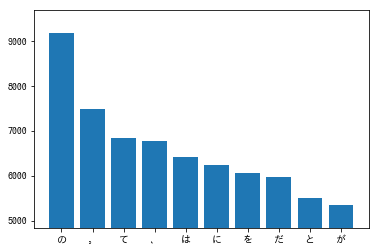

In [21]:
solve37('neko.txt.mecab')

## 38. ヒストグラム
単語の出現頻度のヒストグラム（横軸に出現頻度，縦軸に出現頻度をとる単語の種類数を棒グラフで表したもの）を描け．

In [22]:
%matplotlib inline
def solve38(filename):
    import numpy as np
    from matplotlib import pyplot as plt
    from collections import Counter
    cnt = Counter([t[1] for t in solve36(filename)])
    hist = [t[1] for t in cnt.most_common()]
    x = np.arange(1, len(hist)+1, 1)
    plt.bar(x, hist)
    plt.ylim(0, max(hist)+100)
    plt.xlim(0, 30)
    plt.show()

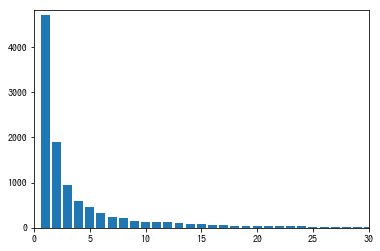

In [23]:
solve38('neko.txt.mecab')

## 39. Zipfの法則
単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．

In [24]:
%matplotlib inline
def solve39(filename):
    import numpy as np
    from matplotlib import pyplot as plt
    res = solve36(filename)
    freq = [t[1] for t in res]
    rank = np.arange(1, len(freq)+1, 1)
    plt.plot(rank, freq)
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.grid()
    plt.show()

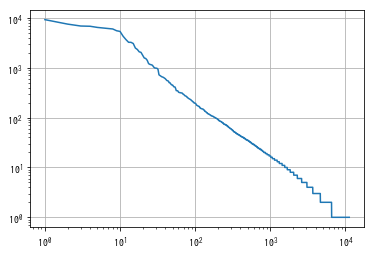

In [25]:
solve39('neko.txt.mecab')

In [26]:
!rm neko.*